# 2 - BigQuery Machine Learning (BQML) - Univariate Forecasting with ARIMA+

In this notebook we will fit a forecasting model to the data reviewed and prepared in the [previous notebook](./1%20-%20BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb) - citibike bike rentals daily volume by station near Central Park in New York City.  For this attempt we will keep the forecasting activity within the data warehouse by using BigQuery's built-in machine learning - often called BQML.  One of the model types available is ARIMA+ (`model_type = 'ARIMA_PLUS`).  This fits univariate forecasts by using auto-regressive integrated moving average (ARIMA) models while also automatically handling many of the data pre and post processing steps required.  Each station will be forecasted separately by simply providing the station names as `start_station_name` to the input `time_series_id_col`.  The forecast will be evaluated with various provided metrics and we will use SQL to calculate customized metrics.  It is even possible to identify anomalies using BigQuery ML with the function `ML.DETECT_ANOMALIES`.

**ARIMA+**

ARIMA is a statistical model of time series data that helps understand patterns and forecast future points in time.  The model is made up of three parts:
- AR, or autoregressive.  Indicates a variable is regressed against it own previous values.
    - `p`, the parameter that indicates the number of lags, or previous time points considered
- I, or integrated.  Indicates the values have been replaced with the difference between a value and the previous value.
    - `d`, the parameter that indicates the degree of differencing or number of times the data have had past value subtracted 
- MA, or moving avarge.  Indicates the regression error is a combination of value at various time in the past.
    - `q`, the parameter that indicates the order of the moving-average

Reference:
- [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)

**BigQuery ML (BQML)**

BigQuery has a number of machine learning algorithms callable directly from SQL.  This gives the convenience of using the common language of `SQL` with statments like `CREATE MODEL …`.  The library of available models is constantly growing and covers supervised, unsupervised, and time series methods as well as functions for evaluation - even anomaly detection from results, explainability and hyperparameter tuning.  A great starting point for seeing the scope of available methods is the [user journey for models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).

**Prerequisites:**
- [1 - BigQuery Time Series Forecasting Data Review and Preparation](./1%20-%20BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb)
    - prepare data for this notebook

**Resources:**
- [Bigquery ML End-to-end user journey for each model](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)
- [How to do time series forecasting in BigQuery](https://towardsdatascience.com/how-to-do-time-series-forecasting-in-bigquery-af9eb6be8159)
- [Vertex AI Forecast: An Overview](https://cloud.google.com/blog/topics/developers-practitioners/vertex-forecast-overview)
- [Codelab: Time Series Forecasting with Vertex AI and BigQuery ML](https://codelabs.developers.google.com/codelabs/time-series-forecasting-with-cloud-ai-platform#0)

**Conceptual Flow & Workflow**
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/afore2_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/afore2_console.png" width="45%">
</p>

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'forecasting-2'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-1'

viz_limit = 12

packages:

In [3]:
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

clients:

In [4]:
bq = bigquery.Client()

---
## Review Time Series

In [6]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'

Retrieve Key Dates for splits:

In [7]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min(date) as mindate, max(date) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE splits ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE splits = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


Retrieve raw data:

In [8]:
query = f"""
    SELECT {SERIES_COLUMN}, date, splits, {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    ORDER by {SERIES_COLUMN}, date
"""
rawSeries = bq.query(query).to_dataframe()

Visualize time series:

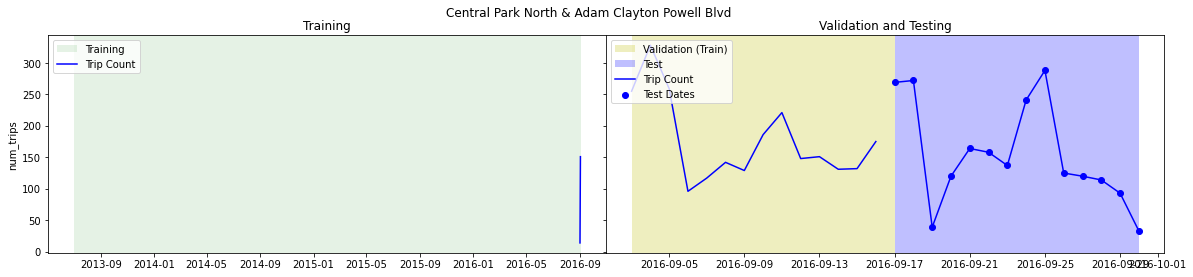

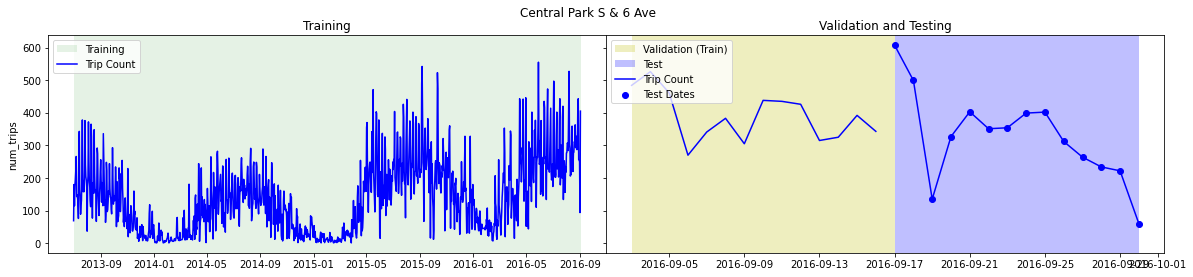

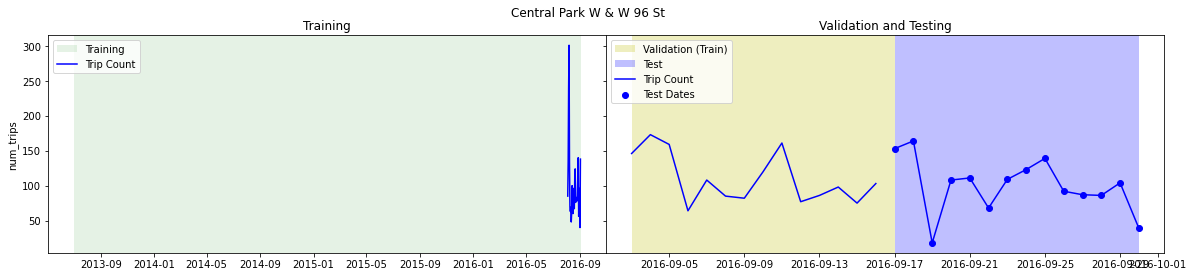

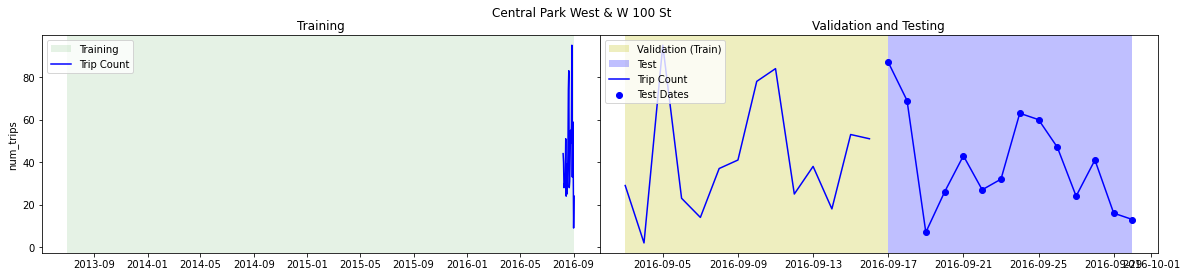

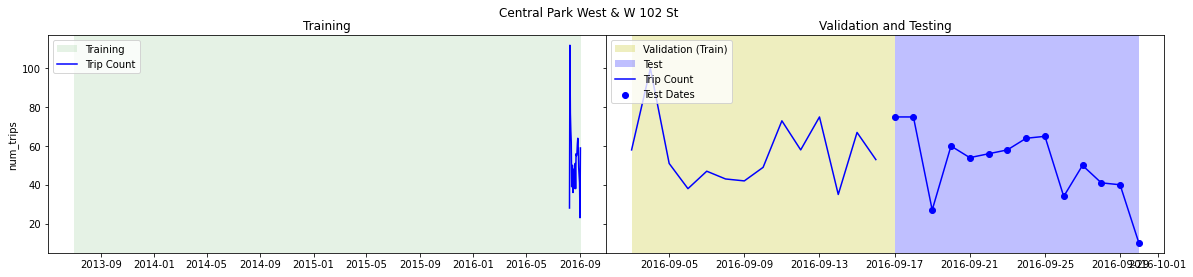

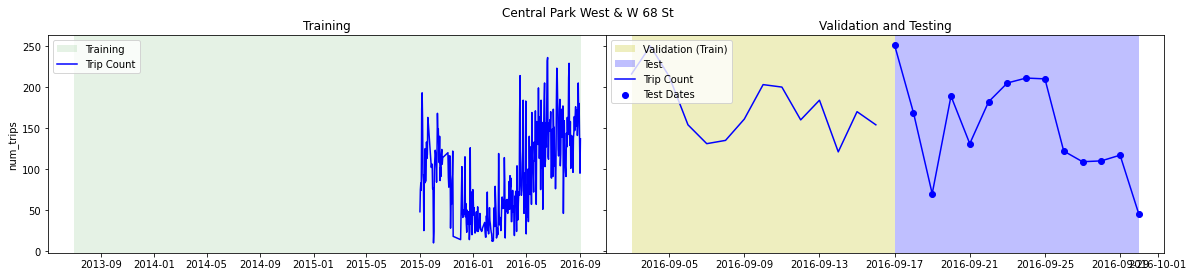

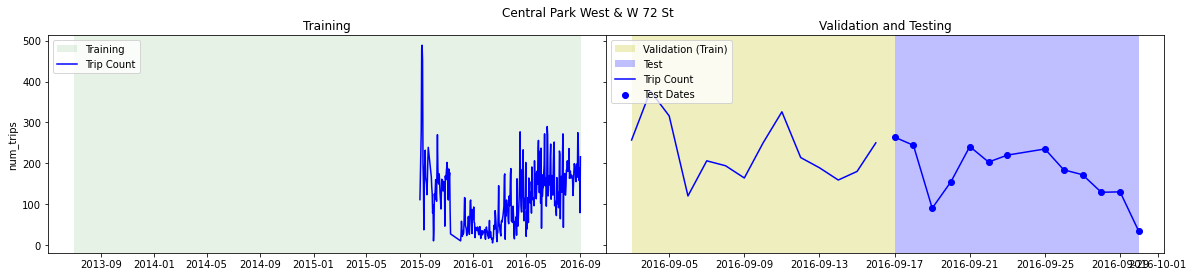

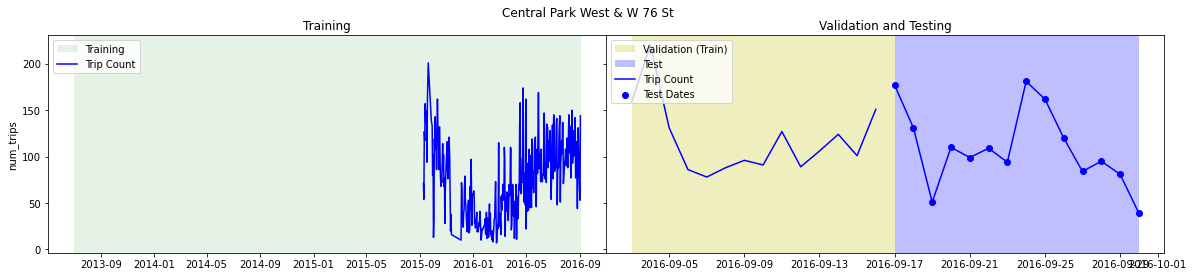

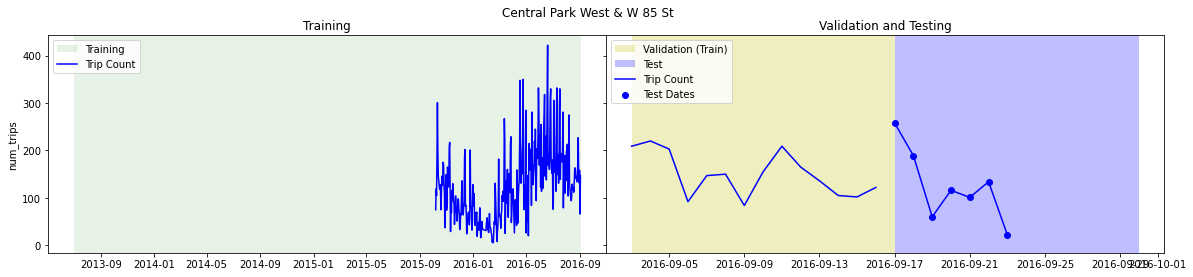

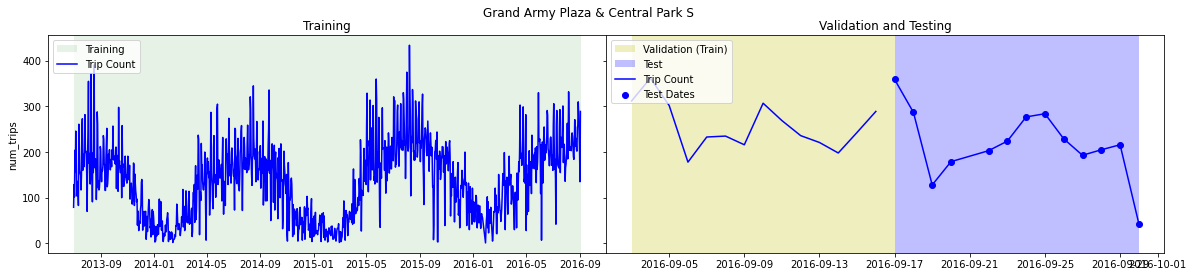

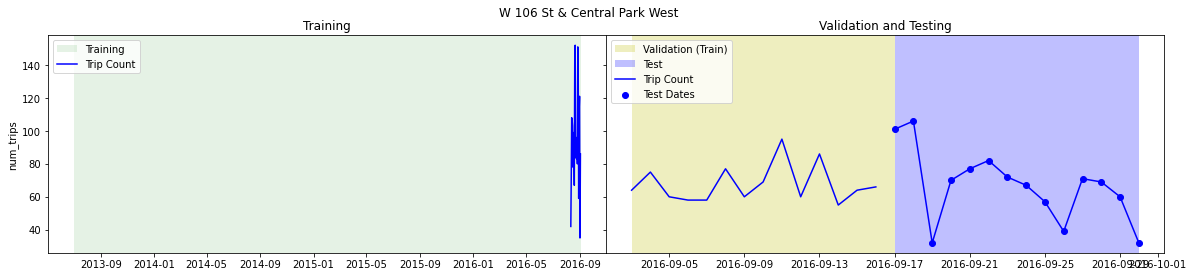

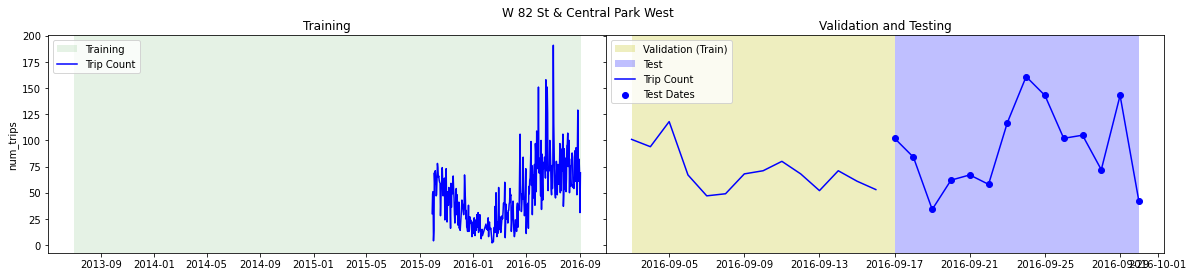

In [10]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf['date'], traindf[TARGET_COLUMN], color = 'b', label = 'Trip Count')
        axes[1].plot(valdf['date'], valdf[TARGET_COLUMN], color = 'b', label = 'Trip Count')
        axes[1].plot(testdf['date'], testdf[TARGET_COLUMN], color = 'b')
        axes[1].scatter(testdf['date'], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # display result
        plt.show()

---
## Create Forecast Model
Use BigQuery ML Arima+ (`model_type = 'ARIMA_PLUS'`), a feature of [BigQuery ML](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).  This does univariate time series modeling using ARIMA while also automating many of the task of this type of inference: preprocessing, holiday adjustments, spikes, dips, outlier, seasonal & trend decomposition, step change adjustment, trend modeling, forecasting.  A representation of this pipeline from the BigQuery ML documentation:

<img src="https://cloud.google.com/bigquery-ml/images/BQ_ARIMA_diagram.png">

Multiple time series are forcasted at the same time, each individual station near Central Park, using the `time_series_id_col = ` input.  ARIMA forecasting is univariate and does not use the validation data so we include it with the training data here:

In [12]:
# CUSTOMIZE
forecast_granularity = 'DAY'
forecast_horizon = 14
forecast_test_length = 14
#forecast_val_length = 14

In [13]:
query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`
    OPTIONS
      (model_type = 'ARIMA_PLUS',
       time_series_timestamp_col = 'date',
       time_series_data_col = '{TARGET_COLUMN}',
       time_series_id_col = '{SERIES_COLUMN}',
       auto_arima_max_order = 5,
       holiday_region = 'US',
       horizon = {forecast_horizon}+{forecast_test_length}
      ) AS
    SELECT {SERIES_COLUMN}, date, {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    WHERE splits in ('TRAIN','VALIDATE')
"""
job = bq.query(query)
job.result()
(job.ended-job.started).total_seconds()

16.166

### Review The ARIMA Coefficients
Reference for [`ML.ARIMA_COEFFICIENTS`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-arima-coefficients)

In [16]:
query = f"""
    SELECT *
    FROM ML.ARIMA_COEFFICIENTS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`)
    ORDER BY {SERIES_COLUMN}
"""
coefficients = bq.query(query).to_dataframe()
coefficients.head(viz_limit)

,start_station_name,ar_coefficients,ma_coefficients,intercept_or_drift
0,Central Park North & Adam Clayton Powell Blvd,[],"[0.4367042956076374, -0.016512649634778276, -0...",169.292694
1,Central Park S & 6 Ave,[],"[-0.761817995770861, -0.29300417780045523, 0.5...",0.000000
2,Central Park W & W 96 St,[0.606197201087799],[],104.092507
3,Central Park West & W 100 St,[0.3518355980348823],[],40.380671
4,Central Park West & W 102 St,[],"[0.024759641179645575, 0.20624615867712248, -0...",52.152300
5,Central Park West & W 68 St,[],"[-0.4883460505394683, 0.14210329297627966, -0....",0.000000
6,Central Park West & W 72 St,[],"[-0.35434051736558037, 0.25549962472257187, -0...",0.000000
7,Central Park West & W 76 St,"[0.6840070790251793, 0.18411990262886785]","[-1.1692985010072334, -0.07919719558810472, 0....",0.331802
8,Central Park West & W 85 St,[],"[-0.3901300567684862, -0.7393964989036537, 0.7...",0.000000
9,Grand Army Plaza & Central Park S,[],"[-0.727360862175811, -0.28971578888243094, 0.5...",0.050564


### Review the input features
Reference for [`ML.FEATURE_INFO`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature)

In [17]:
query = f"""
    SELECT *
    FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`)
"""
featureInfo = bq.query(query).to_dataframe()
featureInfo.head()

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,num_trips,1.0,555.0,119.446128,100.0,87.921883,<NA>,0,<NA>
1,date,NaN,NaN,NaN,NaN,NaN,1170,0,<NA>
2,start_station_name,NaN,NaN,NaN,NaN,NaN,12,0,<NA>


### Review the Training Information
Reference for [`ML.TRAINING_INFO`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train#:~:text=For%20time%20series%20models)

In [18]:
query = f"""
    SELECT *
    FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`)
"""
trainingInfo = bq.query(query).to_dataframe()
trainingInfo.head()

,training_run,iteration,duration_ms
0,0,0,8344


---
## Forecast Evaluation

### Forecast Metrics
Reference for [`ML.EVALUATE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate#:~:text=ml.principal_component_info%20function.-,The%20ML.EVALUATE%20function%20returns,-the%20following%20columns) for `model_type = 'ARIMA_PLUS'`

The metrics returned depend on if input (test) data is provided and if `perform_aggregation` is `True` or `False`.  If `False` then metrics per timestamp are provide, and if `True` then metrics per `time_series_id_col` are provided.

In [19]:
query = f"""
    SELECT *
    FROM ML.EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`,
    (
        SELECT {SERIES_COLUMN}, date, {TARGET_COLUMN}
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
        WHERE splits = 'TEST'
        ORDER BY {SERIES_COLUMN}
    ),
    STRUCT(TRUE AS perform_aggregation))
"""
metrics = bq.query(query).to_dataframe()
metrics.head(viz_limit)

,start_station_name,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,symmetric_mean_absolute_percentage_error
0,Central Park North & Adam Clayton Powell Blvd,40.519533,3339.344260,57.787060,65.497641,32.165275
1,Central Park S & 6 Ave,96.378408,16493.428917,128.426745,48.560143,35.668940
2,Central Park W & W 96 St,21.729312,1016.374801,31.880634,54.169130,27.164336
3,Central Park West & W 100 St,18.610058,482.209233,21.959263,87.537112,50.606040
4,Central Park West & W 102 St,14.568555,332.562812,18.236305,53.150445,32.238560
5,Central Park West & W 68 St,47.347385,3121.343589,55.868986,49.550528,33.573465
6,Central Park West & W 72 St,46.421031,5039.530096,70.989648,67.705235,29.676368
7,Central Park West & W 76 St,29.048562,1358.357295,36.855899,41.280009,28.134669
8,Central Park West & W 85 St,53.979223,4709.508389,68.625858,95.295942,49.453879
9,Grand Army Plaza & Central Park S,55.943225,5654.642570,75.197357,49.869331,30.099746


### Evaluate Time Series Models
Reference for [`ML.ARIMA_EVALUATE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-arima-evaluate)

A per time series, specified with `time_series_id_col` at creation, model metrics table:
ARIMA terms:
- p = how many autoregressive terms
- d =  how many nonseasonal differences needed for stationarity
- q = number of lagged forecast errors (moving average part)


In [21]:
query = f"""
    SELECT *
    FROM ML.ARIMA_EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`)
    ORDER BY {SERIES_COLUMN}
"""
arima_metrics = bq.query(query).to_dataframe()
arima_metrics.head(viz_limit)

,start_station_name,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes,error_message
0,Central Park North & Adam Clayton Powell Blvd,0,0,4,False,-76.109993,164.219985,536.704789,[WEEKLY],False,False,False,
1,Central Park S & 6 Ave,0,1,5,False,-5797.510106,11607.020213,1144.923258,"[WEEKLY, YEARLY]",True,True,True,
2,Central Park W & W 96 St,1,0,0,False,-210.602099,427.204198,832.585329,[WEEKLY],False,False,False,
3,Central Park West & W 100 St,1,0,0,False,-175.395825,356.791651,375.632216,[NO_SEASONALITY],False,True,False,
4,Central Park West & W 102 St,0,0,4,False,-165.517414,343.034827,189.056029,[NO_SEASONALITY],False,False,False,
5,Central Park West & W 68 St,0,1,5,False,-1711.902965,3435.805930,465.051764,[WEEKLY],True,True,True,
6,Central Park West & W 72 St,0,1,5,False,-1836.246650,3684.493301,881.974534,[WEEKLY],True,True,True,
7,Central Park West & W 76 St,2,1,3,True,-1523.623260,3061.246521,204.783538,[WEEKLY],True,True,True,
8,Central Park West & W 85 St,0,1,5,False,-1710.216785,3432.433571,1121.729390,[WEEKLY],False,True,False,
9,Grand Army Plaza & Central Park S,0,1,5,True,-5447.166291,10908.332582,630.175960,"[WEEKLY, YEARLY]",True,True,True,


---
## Forecast Time Series
Reference for [`ML.FORECAST`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-forecast)

Calcualtes the forecasted value per timestamp and provides standard error and prediction intervals at the requested confidence level.

The default `horizon` is 3 so this parameter may need to be set to the size used at training.

In [23]:
query = f"""
    SELECT *
    FROM ML.FORECAST(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`, STRUCT(1 AS horizon, 0.95 AS confidence_level))
    ORDER BY {SERIES_COLUMN}
"""
forecast = bq.query(query).to_dataframe()
forecast.head(viz_limit)

,start_station_name,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,Central Park North & Adam Clayton Powell Blvd,2016-09-17 00:00:00+00:00,222.073810,25.307050,0.95,172.561627,271.585993,172.561627,271.585993
1,Central Park S & 6 Ave,2016-09-17 00:00:00+00:00,359.884999,33.836715,0.95,293.684885,426.085113,293.684885,426.085113
2,Central Park W & W 96 St,2016-09-17 00:00:00+00:00,122.160526,28.854555,0.95,65.707799,178.613253,65.707799,178.613253
3,Central Park West & W 100 St,2016-09-17 00:00:00+00:00,44.116929,19.381234,0.95,6.198358,82.035500,6.198358,82.035500
4,Central Park West & W 102 St,2016-09-17 00:00:00+00:00,45.519928,14.227731,0.95,17.683968,73.355888,17.683968,73.355888
5,Central Park West & W 68 St,2016-09-17 00:00:00+00:00,175.947186,21.565059,0.95,133.756052,218.138319,133.756052,218.138319
6,Central Park West & W 72 St,2016-09-17 00:00:00+00:00,271.568957,29.709519,0.95,213.443528,329.694385,213.443528,329.694385
7,Central Park West & W 76 St,2016-09-17 00:00:00+00:00,147.200095,14.328406,0.95,119.167170,175.233020,119.167170,175.233020
8,Central Park West & W 85 St,2016-09-17 00:00:00+00:00,125.442298,33.683213,0.95,59.542503,191.342093,59.542503,191.342093
9,Grand Army Plaza & Central Park S,2016-09-17 00:00:00+00:00,258.873310,25.103306,0.95,209.759744,307.986875,209.759744,307.986875


## Forecast + Explainations for Time Series
Reference for [`ML.EXPLAIN_FORECAST`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-forecast)

BigQuery ML has an enhanced forecasting function that also include explaination information.  One of the default parameters for the `model_type = 'ARIMA_PLUS'` is `decompost_timer_series = True` which enable this functionality.

In addition to forecast an the accompanying prediction intervals, this also includes the actual value and infromation for trend, seasonality, holiday effects, spikes and dips, and step changes.

In [24]:
query = f"""
    SELECT *, EXTRACT(DATE FROM time_series_timestamp) AS date
    FROM ML.EXPLAIN_FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`,
        STRUCT({forecast_horizon+forecast_test_length} AS horizon, 0.95 AS confidence_level))
    ORDER BY {SERIES_COLUMN}, time_series_timestamp
"""
explain = bq.query(query).to_dataframe()

In [25]:
explain.tail()

,start_station_name,time_series_timestamp,time_series_type,time_series_data,time_series_adjusted_data,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,trend,seasonal_period_yearly,seasonal_period_quarterly,seasonal_period_monthly,seasonal_period_weekly,seasonal_period_daily,holiday_effect,spikes_and_dips,step_changes,date
4694,W 82 St & Central Park West,2016-10-10 00:00:00+00:00,forecast,73.385875,73.385875,21.976428,0.95,30.389914,116.381836,69.507656,NaN,NaN,NaN,3.878220,NaN,NaN,NaN,NaN,2016-10-10
4695,W 82 St & Central Park West,2016-10-11 00:00:00+00:00,forecast,67.075769,67.075769,22.103553,0.95,23.831094,110.320444,69.507656,NaN,NaN,NaN,-2.431887,NaN,NaN,NaN,NaN,2016-10-11
4696,W 82 St & Central Park West,2016-10-12 00:00:00+00:00,forecast,58.180525,58.180525,22.229951,0.95,14.688558,101.672492,69.507656,NaN,NaN,NaN,-11.327131,NaN,NaN,NaN,NaN,2016-10-12
4697,W 82 St & Central Park West,2016-10-13 00:00:00+00:00,forecast,43.376116,43.376116,22.355634,0.95,-0.361745,87.113977,69.507656,NaN,NaN,NaN,-26.131540,NaN,NaN,NaN,NaN,2016-10-13
4698,W 82 St & Central Park West,2016-10-14 00:00:00+00:00,forecast,66.707370,66.707370,22.480614,0.95,22.724990,110.689750,69.507656,NaN,NaN,NaN,-2.800286,NaN,NaN,NaN,NaN,2016-10-14


### Visualize Time Series with Forecast

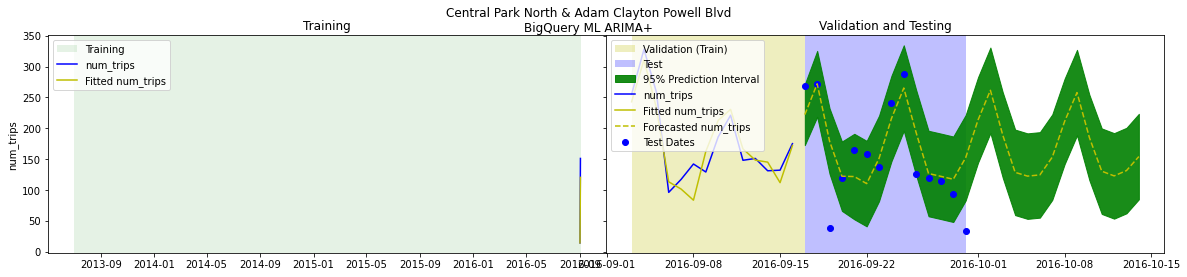

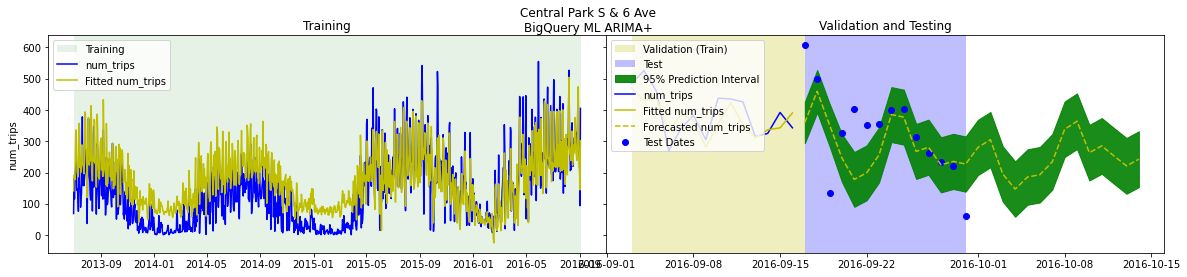

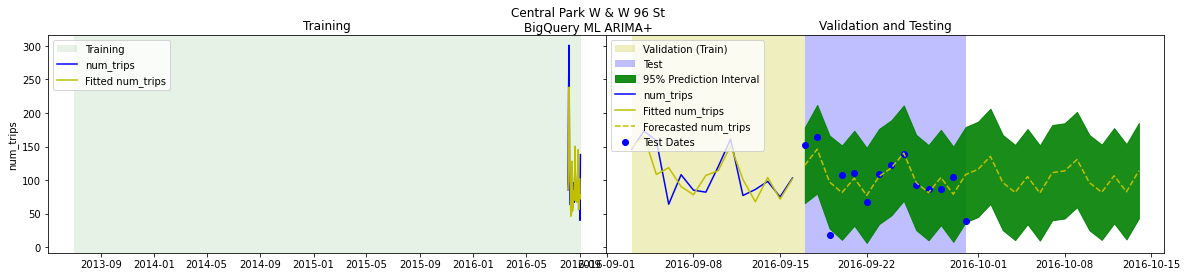

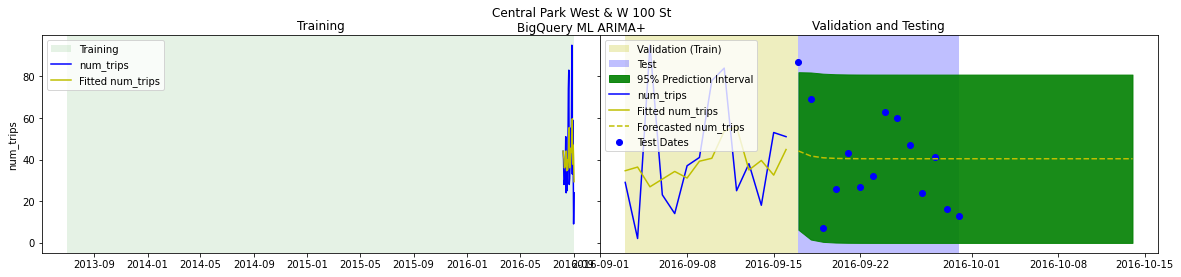

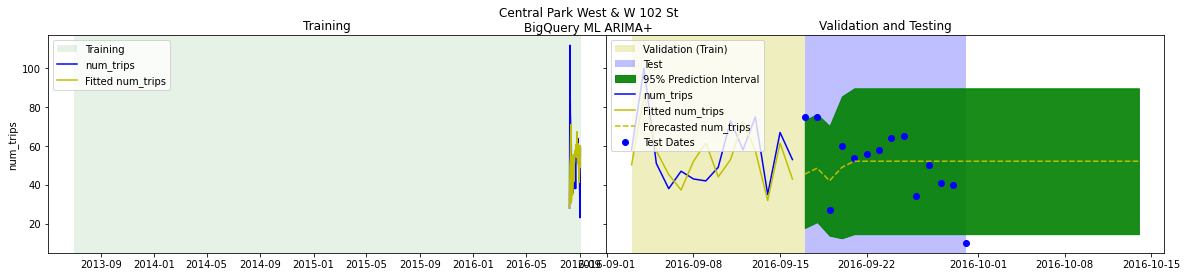

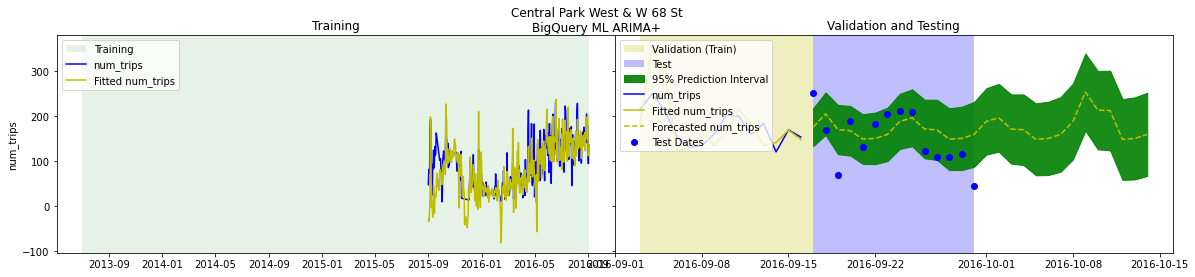

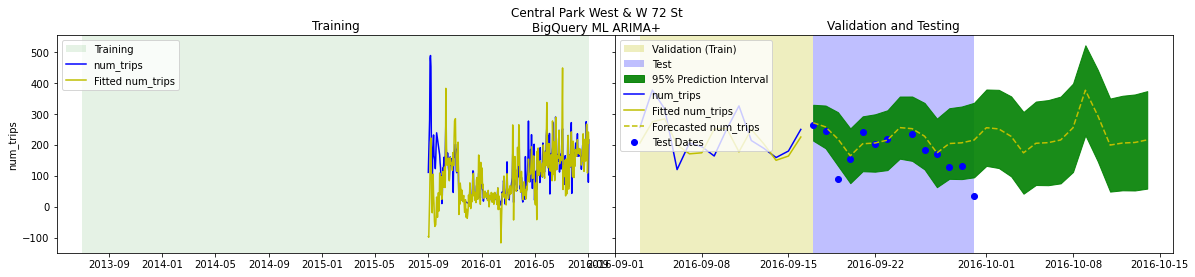

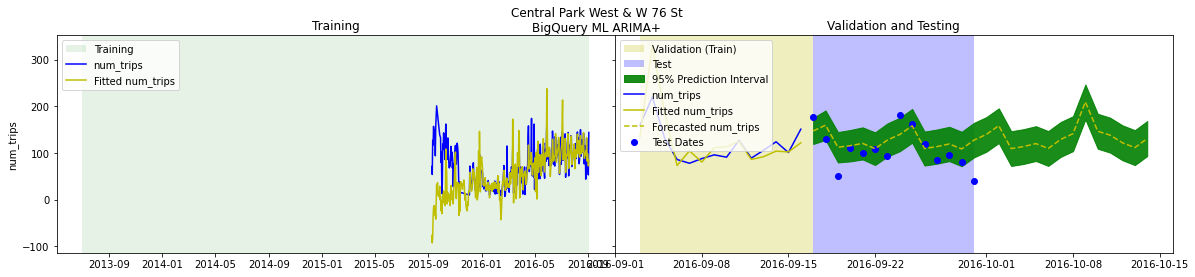

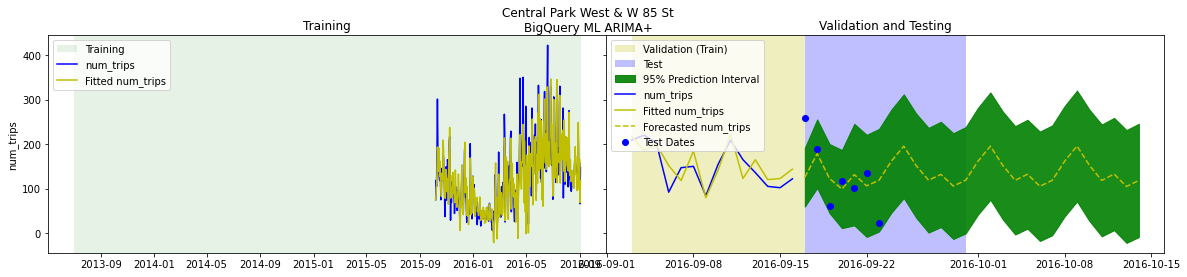

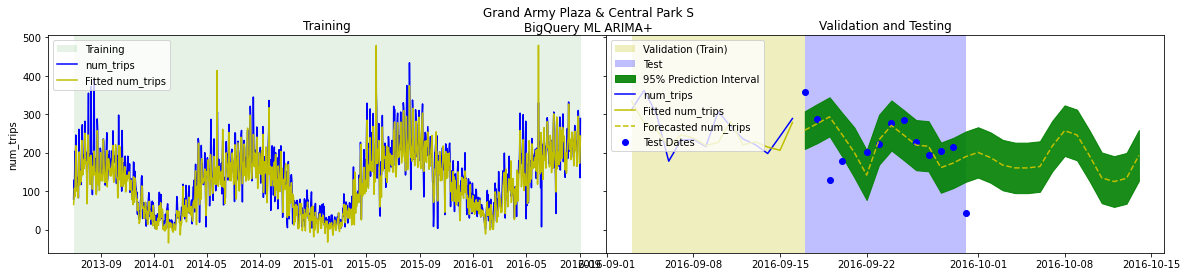

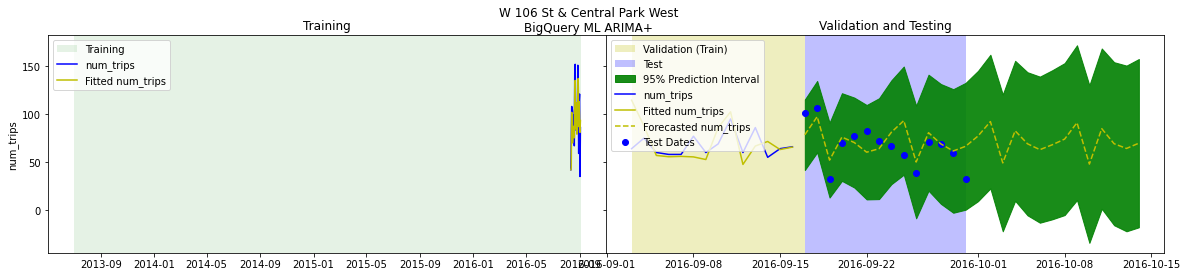

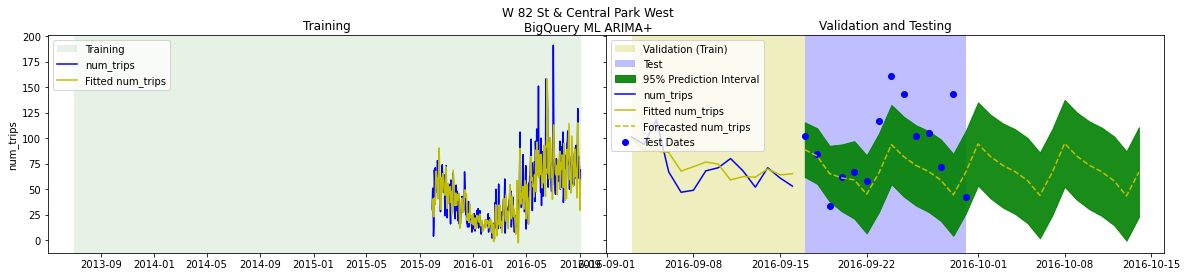

In [31]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]
        fit_traindf = explain[(explain[SERIES_COLUMN] == st) & (explain['date'] < keyDates['val_start'][0])]
        fit_valdf = explain[(explain[SERIES_COLUMN] == st) & (explain['date'] >= keyDates['val_start'][0]) & (explain['date'] < keyDates['test_start'][0])]
        fit_testdf = explain[(explain[SERIES_COLUMN] == st) & (explain['date'] >= keyDates['test_start'][0])]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
        axes[1].fill_between(fit_testdf['date'], fit_testdf['prediction_interval_lower_bound'], fit_testdf['prediction_interval_upper_bound'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')

        # lines and dots
        axes[0].plot(traindf['date'], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf['date'], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        #axes[1].plot(testdf['date'], testdf[TARGET_COLUMN], color = 'b')

        axes[0].plot(fit_traindf['date'], fit_traindf['time_series_adjusted_data'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_valdf['date'], fit_valdf['time_series_adjusted_data'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_testdf['date'], fit_testdf['time_series_adjusted_data'], color = 'y', label = f'Forecasted {TARGET_COLUMN}', linestyle='dashed')

        axes[1].scatter(testdf['date'], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st + f"\nBigQuery ML ARIMA+")

        # display result
        plt.show()

## Using SQL to Calculate Metrics

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divided by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE, or Mean Squared Error
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE, or Root Mean Squared Error
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- RMSE divided by average demand so it yeilds a % like MAPE
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$

It can be helpful to explicity caculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

In [27]:
query = f"""
WITH
    FORECAST AS (
        SELECT
            {SERIES_COLUMN}, 
            EXTRACT(DATE from time_series_timestamp) as date,
            time_series_adjusted_data as forecast_value,
            time_series_type
        FROM ML.EXPLAIN_FORECAST(
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`,
            STRUCT({forecast_test_length} AS horizon, 0.95 AS confidence_level))
        WHERE time_series_type = 'forecast'
    ),
    ACTUAL AS (
        SELECT {SERIES_COLUMN}, date, sum({TARGET_COLUMN}) as actual_value
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
        WHERE splits = 'TEST'
        GROUP BY {SERIES_COLUMN}, date
    ),
    COMBINED AS (
        SELECT *
        FROM FORECAST
        INNER JOIN ACTUAL
        USING ({SERIES_COLUMN}, date)  
    ),
    DIFFS AS (
        SELECT {SERIES_COLUMN}, date, 'forecast' as time_series_type, 
            actual_value, forecast_value, (actual_value - forecast_value) as diff
        FROM COMBINED
    )
SELECT {SERIES_COLUMN}, time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE,
    AVG(POW(diff, 2)) as MSE,
    SQRT(AVG(POW(diff, 2))) as RMSE,
    SQRT(AVG(POW(diff, 2)))/AVG(actual_value) as pRMSE
FROM DIFFS
GROUP BY {SERIES_COLUMN}, time_series_type
ORDER BY {SERIES_COLUMN}, time_series_type    
"""
customMetrics = bq.query(query = query).to_dataframe()
customMetrics.head(viz_limit)

,start_station_name,time_series_type,MAPE,MAE,pMAE,MSE,RMSE,pRMSE
0,Central Park North & Adam Clayton Powell Blvd,forecast,0.654976,40.519533,0.261055,3339.344260,57.787060,0.372305
1,Central Park S & 6 Ave,forecast,0.485601,96.378408,0.295316,16493.428917,128.426745,0.393516
2,Central Park W & W 96 St,forecast,0.541691,21.729312,0.217138,1016.374801,31.880634,0.318579
3,Central Park West & W 100 St,forecast,0.875371,18.610058,0.469443,482.209233,21.959263,0.553927
4,Central Park West & W 102 St,forecast,0.531504,14.568555,0.287672,332.562812,18.236305,0.360096
5,Central Park West & W 68 St,forecast,0.495505,47.347385,0.312524,3121.343589,55.868986,0.368772
6,Central Park West & W 72 St,forecast,0.677052,46.421031,0.262380,5039.530096,70.989648,0.401246
7,Central Park West & W 76 St,forecast,0.412800,29.048562,0.265284,1358.357295,36.855899,0.336584
8,Central Park West & W 85 St,forecast,0.952959,53.979223,0.429380,4709.508389,68.625858,0.545888
9,Grand Army Plaza & Central Park S,forecast,0.498693,55.943225,0.257256,5654.642570,75.197357,0.345796


Overall Metrics:

In [28]:
query = f"""
    WITH
        FORECAST AS (
            SELECT
                {SERIES_COLUMN}, 
                EXTRACT(DATE from time_series_timestamp) as date,
                time_series_adjusted_data as forecast_value,
                time_series_type
            FROM ML.EXPLAIN_FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`, 
                STRUCT({forecast_test_length} AS horizon, 0.95 AS confidence_level))
            WHERE time_series_type = 'forecast'
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, date, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            WHERE splits = 'TEST'
            GROUP BY {SERIES_COLUMN}, date
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, date)  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, date, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT time_series_type, 
        AVG(ABS(diff)/actual_value) as MAPE,
        AVG(ABS(diff)) as MAE,
        SUM(ABS(diff))/SUM(actual_value) as pMAE,
        AVG(POW(diff, 2)) as MSE,
        SQRT(AVG(POW(diff, 2))) as RMSE,
        SQRT(AVG(POW(diff, 2)))/AVG(actual_value) as pRMSE
    FROM DIFFS
    GROUP BY time_series_type
    ORDER BY time_series_type    
"""
customMetricsOverall = bq.query(query).to_dataframe()
customMetricsOverall

,time_series_type,MAPE,MAE,pMAE,MSE,RMSE,pRMSE
0,forecast,0.544483,38.452852,0.28711,3568.981762,59.740955,0.446058


---
## Anomaly Detection
Reference for [`ML.DETECT_ANOMALIES`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-detect-anomalies)


In [30]:
query = f"""
    SELECT * EXCEPT(date), CAST(DATE(date) AS date) AS date
    FROM ML.DETECT_ANOMALIES(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`,
        STRUCT(0.95 as anomaly_prob_threshold))
    WHERE anomaly_probability >= 0.95
"""
anomalies = bq.query(query).to_dataframe()
anomalies.head(viz_limit)

,start_station_name,num_trips,is_anomaly,lower_bound,upper_bound,anomaly_probability,date
0,Central Park North & Adam Clayton Powell Blvd,142.0,True,37.979852,128.629950,0.988419,2016-09-08
1,Central Park S & 6 Ave,175.0,True,39.055644,171.455872,0.961026,2013-07-04
2,Central Park S & 6 Ave,89.0,True,110.045475,242.445703,0.989745,2013-07-17
3,Central Park S & 6 Ave,378.0,True,144.484610,276.884838,0.999987,2013-07-21
4,Central Park S & 6 Ave,242.0,True,250.114403,382.514631,0.972062,2013-07-28
5,Central Park S & 6 Ave,206.0,True,221.076814,353.477042,0.983551,2013-08-03
6,Central Park S & 6 Ave,372.0,True,237.706209,370.106437,0.956187,2013-08-04
7,Central Park S & 6 Ave,214.0,True,226.446091,358.846319,0.979847,2013-08-18
8,Central Park S & 6 Ave,293.0,True,154.531753,286.931981,0.967521,2013-09-28
9,Central Park S & 6 Ave,51.0,True,66.925928,199.326156,0.984606,2013-10-07


### Visualize Time Series with Forecast and Anomalies

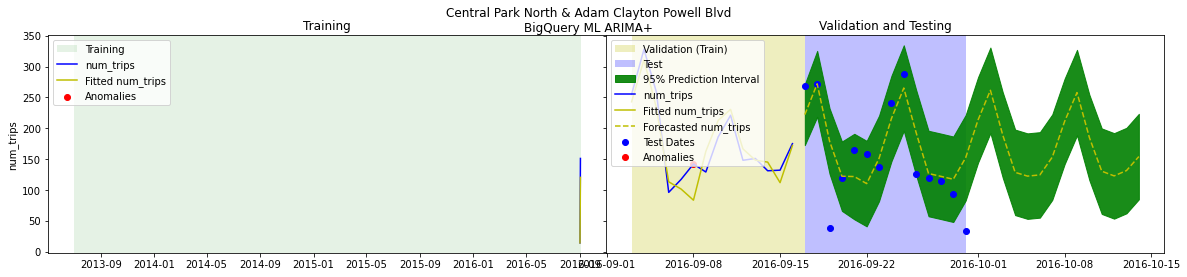

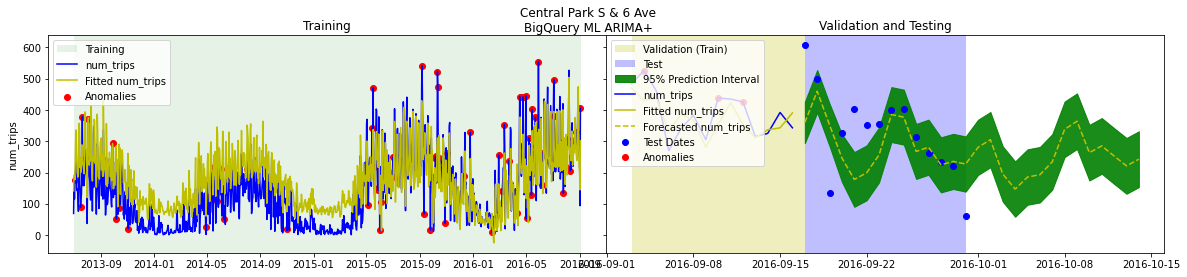

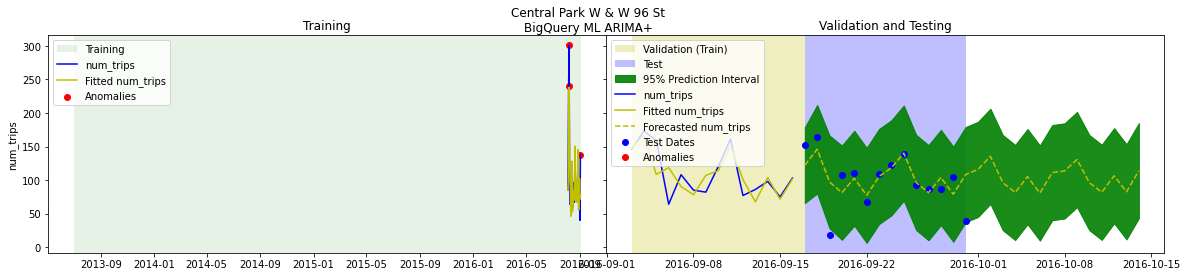

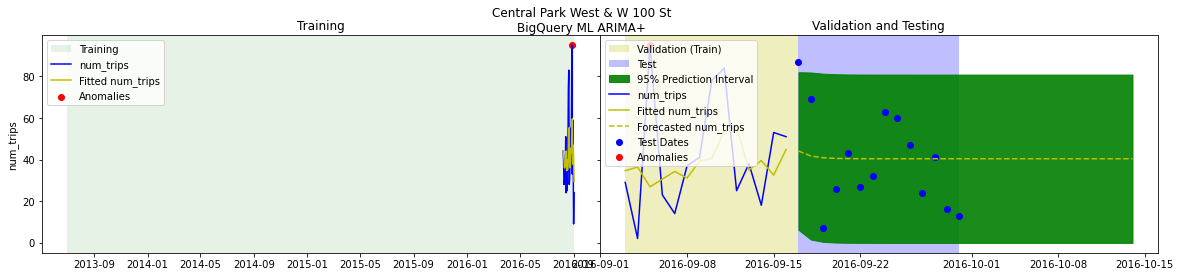

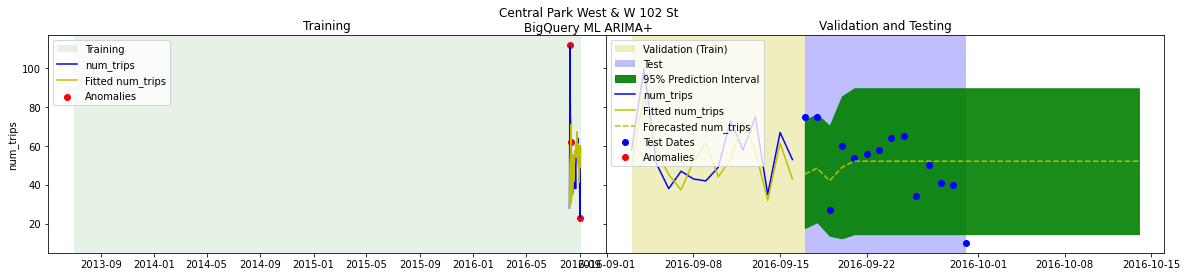

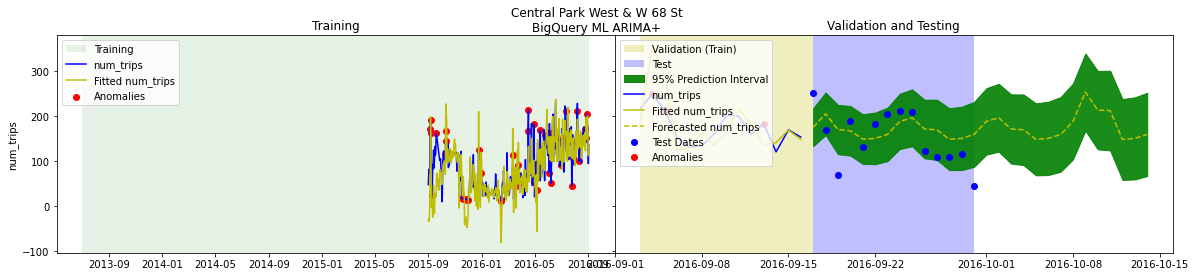

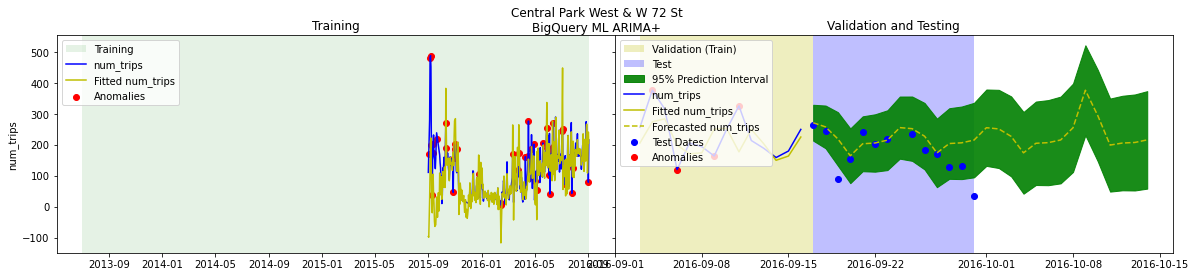

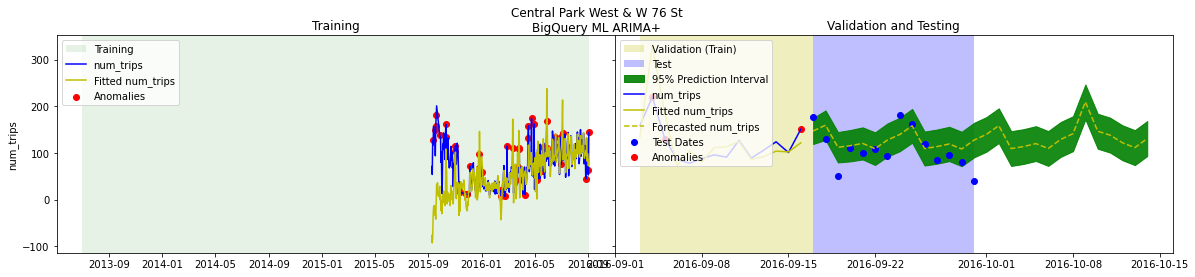

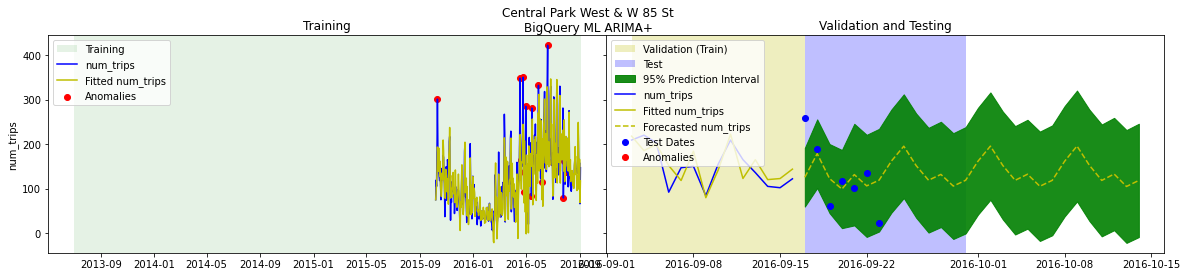

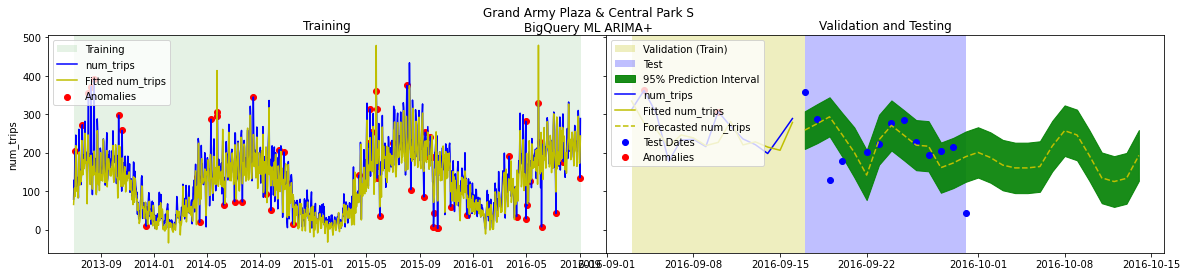

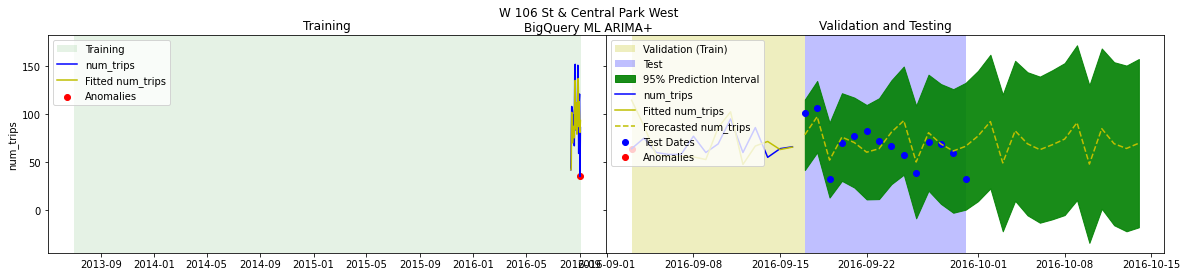

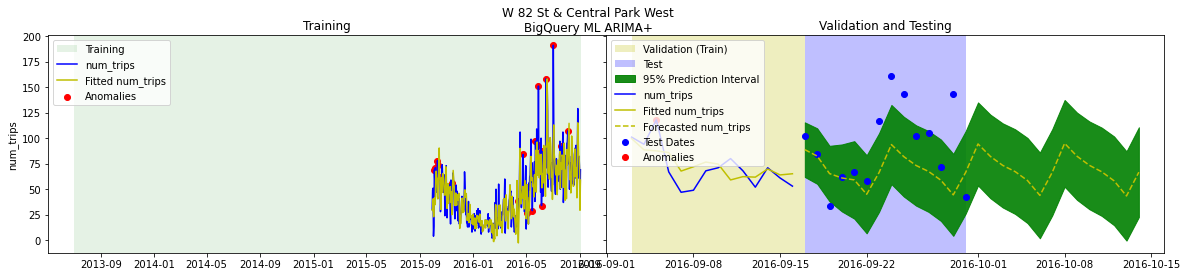

In [32]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]
        fit_traindf = explain[(explain[SERIES_COLUMN] == st) & (explain['date'] < keyDates['val_start'][0])]
        fit_valdf = explain[(explain[SERIES_COLUMN] == st) & (explain['date'] >= keyDates['val_start'][0]) & (explain['date'] < keyDates['test_start'][0])]
        fit_testdf = explain[(explain[SERIES_COLUMN] == st) & (explain['date'] >= keyDates['test_start'][0])]
        anomalies_traindf = anomalies[(anomalies[SERIES_COLUMN] == st) & (anomalies['date'] < keyDates['val_start'][0])]
        anomalies_valdf = anomalies[(anomalies[SERIES_COLUMN] == st) & (anomalies['date'] >= keyDates['val_start'][0])]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
        axes[1].fill_between(fit_testdf['date'], fit_testdf['prediction_interval_lower_bound'], fit_testdf['prediction_interval_upper_bound'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')

        # lines and dots
        axes[0].plot(traindf['date'], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf['date'], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        #axes[1].plot(testdf['date'], testdf[TARGET_COLUMN], color = 'b')

        axes[0].plot(fit_traindf['date'], fit_traindf['time_series_adjusted_data'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_valdf['date'], fit_valdf['time_series_adjusted_data'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_testdf['date'], fit_testdf['time_series_adjusted_data'], color = 'y', label = f'Forecasted {TARGET_COLUMN}', linestyle='dashed')

        axes[1].scatter(testdf['date'], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')

        axes[0].scatter(anomalies_traindf['date'], anomalies_traindf[TARGET_COLUMN], color = 'r', label = 'Anomalies')
        axes[1].scatter(anomalies_valdf['date'], anomalies_valdf[TARGET_COLUMN], color = 'r', label = 'Anomalies')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st + f"\nBigQuery ML ARIMA+")

        # display result
        plt.show()

---
## Remove Resources
see notebook "99 - Cleanup"